In [127]:
import os
import re
import json
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
import tensorflow_io as tfio
print(tfio.__version__)

from tensorflow.keras import layers
from tensorflow.keras import models

import wandb
from wandb.keras import WandbMetricsLogger

2.10.0
0.27.0


In [3]:
data_path = "../data/tfrecords"


def natural_keys(text):
    ""
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    return [atoi(c) for c in re.split(r'(\d+)', text)]

tfrecords = sorted(glob(f"{data_path}/*.tfrec"), key=natural_keys)

In [4]:
train_tfrecords, valid_tfrecords = tfrecords[:19], tfrecords[19:]
print(len(train_tfrecords)+len(valid_tfrecords))

24


In [158]:
LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

RIGHT_EYE = [
    246, 161, 160, 159, 158, 157, 173,
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    247, 30, 29, 27, 28, 56, 190,
    130, 25, 110, 24, 23, 22, 26, 112, 243,
    113, 225, 224, 223, 222, 221, 189,
    226, 31, 228, 229, 230, 231, 232, 233, 244,
    143, 111, 117, 118, 119, 120, 121, 128, 245,
]

LEFT_EYE = [
    466, 387, 386, 385, 384, 398,
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    467, 260, 259, 257, 258, 286, 414,
    359, 255, 339, 254, 253, 252, 256, 341, 463,
    342, 445, 444, 443, 442, 441, 413,
    446, 261, 448, 449, 450, 451, 452, 453, 464,
    372, 340, 346, 347, 348, 349, 350, 357, 465,
]

LEFT_HAND = [
    468, 469, 470, 471, 472, 473, 474, 475,
    476, 477, 478, 479, 480, 481, 482, 483, 484,
    485, 486, 487, 488
]

RIGHT_HAND = [
    522, 523, 524, 525, 526, 527, 528, 529,
    530, 531, 532, 533, 534, 535, 536, 537,
    538, 539, 540, 541, 542
]

In [185]:
samples

<tf.Tensor: shape=(56, 543, 3), dtype=float32, numpy=
array([[[ 0.49440014,  0.38046983, -0.03062646],
        [ 0.49601725,  0.3507348 , -0.05756483],
        [ 0.5008185 ,  0.35934305, -0.03028346],
        ...,
        [ 0.31373617,  0.41234398, -0.05269891],
        [ 0.35072815,  0.39958185, -0.06021732],
        [ 0.38579622,  0.4011007 , -0.06471767]],

       [[ 0.5011503 ,  0.38055426, -0.03156953],
        [ 0.49290648,  0.3493601 , -0.05817606],
        [ 0.49832708,  0.3581275 , -0.03118932],
        ...,
        [ 0.33588555,  0.3889878 , -0.0631762 ],
        [ 0.37742943,  0.3802519 , -0.07176355],
        [ 0.41639116,  0.38289747, -0.076529  ]],

       [[ 0.49847096,  0.37949273, -0.0309729 ],
        [ 0.49176967,  0.34847346, -0.05721497],
        [ 0.49767977,  0.3573629 , -0.03084622],
        ...,
        [ 0.35855788,  0.3844513 , -0.06097187],
        [ 0.4005313 ,  0.37769613, -0.07045607],
        [ 0.43907768,  0.37987   , -0.07860945]],

       ...,

      

In [186]:
tf.linalg.normalize(
    samples, ord='euclidean', axis=0
)

(<tf.Tensor: shape=(56, 543, 3), dtype=float32, numpy=
 array([[[ 0.19528916,  0.20987992, -0.17001705],
         [ 0.19681904,  0.21111827, -0.19591726],
         [ 0.1975499 ,  0.2103818 , -0.18124647],
         ...,
         [ 0.314577  ,  0.27565095, -0.1795813 ],
         [ 0.32099906,  0.27882108, -0.1831989 ],
         [ 0.324138  ,  0.2879097 , -0.1839161 ]],
 
        [[ 0.19795549,  0.2099265 , -0.1752523 ],
         [ 0.19558468,  0.2102908 , -0.19799754],
         [ 0.19656715,  0.20967016, -0.18666805],
         ...,
         [ 0.33678576,  0.2600374 , -0.21528462],
         [ 0.34543702,  0.265333  , -0.21832593],
         [ 0.34984323,  0.27484342, -0.2174818 ]],
 
        [[ 0.19689715,  0.20934092, -0.17194022],
         [ 0.19513361,  0.2097571 , -0.19472654],
         [ 0.19631182,  0.2092225 , -0.18461463],
         ...,
         [ 0.35951886,  0.25700474, -0.20777294],
         [ 0.3665807 ,  0.26354963, -0.21434817],
         [ 0.36890396,  0.27267033, -0.22339407

In [208]:
def parse_sequence(serialized_sequence):
    return tf.io.parse_tensor(
        serialized_sequence,
        out_type=tf.float32,
    )


def parse_tfrecord_fn(example):
    feature_description = {
        "n_frames": tf.io.FixedLenFeature([], tf.float32),
        "frames": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    
    return tf.io.parse_single_example(example, feature_description)


NUM_FRAMES = 56

def true_fn(frames, n_frames):
    num_left_frames = NUM_FRAMES - n_frames
    left_frames = tf.zeros(shape=(num_left_frames, 543, 3))
    frames = tf.concat([frames, left_frames], 0)

    return frames


def false_fn(frames):
    frames = tf.slice(
        frames,
        begin=[0,0,0],
        size=[NUM_FRAMES, 543, 3]
    )
    
    return frames


@tf.function
def preprocess_frames(frames, n_frames):
    """This is where different preprocessing logics will be experimented."""
#     # nan to num
    frames = tf.where(tf.math.is_nan(frames), 0.0, frames)
    
    # sample frames
    frames = tf.cond(
        tf.less(n_frames, NUM_FRAMES),
        true_fn = lambda: true_fn(frames, n_frames),
        false_fn = lambda: false_fn(frames),
    )
    
    # Get lips and hands
    lips = tf.gather(frames, indices=LIP, axis=1)
#     rh = tf.gather(frames, indices=RIGHT_HAND, axis=1)
#     lh = tf.gather(frames, indices=RIGHT_HAND, axis=1)
#     frames = tf.concat([lips, rh, lh], axis=1)
    
    return lips


# def normalize_frames(frames):
#     """
#     Normalize each video
#     """
#     not_nan_frames = frames[~tf.math.is_nan(frames)]

#     frames -= tf.math.reduce_mean(not_nan_frames, axis=0, keepdims=True)
#     frames /= tf.math.reduce_std(not_nan_frames, axis=0, keepdims=True)

#     frames = tf.where(tf.math.is_finite(frames), frames, tf.zeros_like(frames))
    
#     return frames


def normalize_frames(frames):
    frames = tf.linalg.normalize(
        frames, ord="euclidean", axis=0
    )

    return frames[0]


def parse_data(example, normalize=False):
    # Parse Frames
    n_frames = example["n_frames"]
    frames = tf.reshape(parse_sequence(example["frames"]), shape=(n_frames, 543, 3))
    frames = preprocess_frames(frames, n_frames)
    
    if normalize:
        frames = normalize_frames(frames)
#     else:
#         frames = tf.where(tf.math.is_finite(frames), frames, tf.zeros_like(frames))

    # Parse Labels
    label = tf.one_hot(example["label"], depth=250)

    return frames, label

In [209]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.TFRecordDataset(train_tfrecords)
valid_ds = tf.data.TFRecordDataset(valid_tfrecords)

trainloader = (
    train_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(partial(parse_data, normalize=False), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

trainloader_norm = (
    train_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(partial(parse_data, normalize=True), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [210]:
unnormalized_samples = []

for sample, _ in trainloader.take(1000):
    unnormalized_samples.append(sample.numpy())
    
unnormalized_samples = np.array(unnormalized_samples)

In [211]:
normalized_samples = []

for sample, _ in trainloader_norm.take(1000):
    normalized_samples.append(sample.numpy())
    
normalized_samples = np.array(normalized_samples)

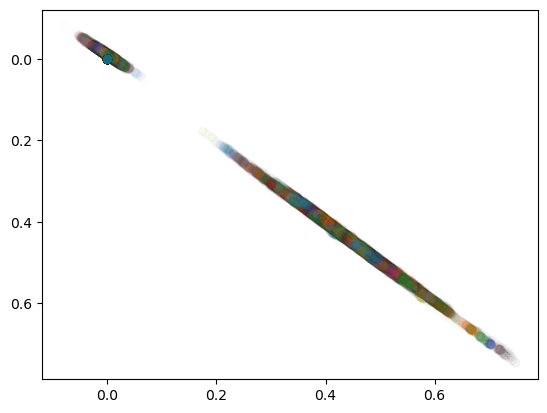

In [212]:
fig, ax = plt.subplots()
ax.invert_yaxis()

for sample in unnormalized_samples:
    ax.scatter(sample[:,0], sample[:,1], alpha=0.01)

In [214]:
sample[:,0]

array([[ 0.2258059 ,  0.23585694,  0.4741524 ],
       [ 0.22566569,  0.23313874,  0.38418385],
       [ 0.2257895 ,  0.23009363,  0.14705485],
       [ 0.22785075,  0.22871372,  0.07227965],
       [ 0.23046997,  0.22756505, -0.03017426],
       [ 0.23161866,  0.22681886, -0.03330976],
       [ 0.23218772,  0.22661448, -0.07024507],
       [ 0.23130143,  0.22755007,  0.09622556],
       [ 0.23106457,  0.2276258 ,  0.12863684],
       [ 0.23030964,  0.22740936,  0.20180225],
       [ 0.23036373,  0.22744551,  0.18306375],
       [ 0.230702  ,  0.22760858,  0.17882463],
       [ 0.23112424,  0.2277234 ,  0.06409346],
       [ 0.23214817,  0.22797863, -0.11549723],
       [ 0.23199308,  0.22864905, -0.02254399],
       [ 0.2307061 ,  0.22987334,  0.08557017],
       [ 0.22792564,  0.23137236,  0.1401226 ],
       [ 0.22571354,  0.23242061,  0.43883196],
       [ 0.2259127 ,  0.23415005,  0.47357252],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

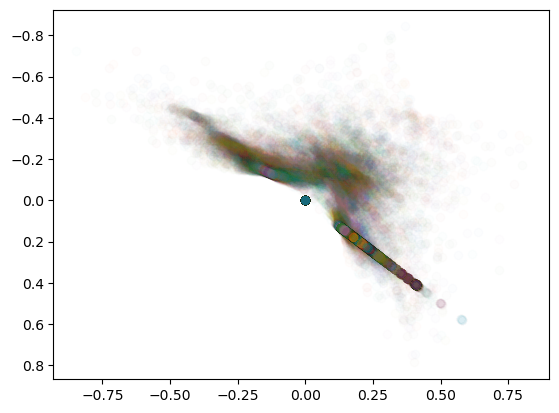

In [213]:
# Euclidean
fig, ax = plt.subplots()
ax.invert_yaxis()

for sample in normalized_samples:
    ax.scatter(sample[:,0], sample[:,1], alpha=0.01)

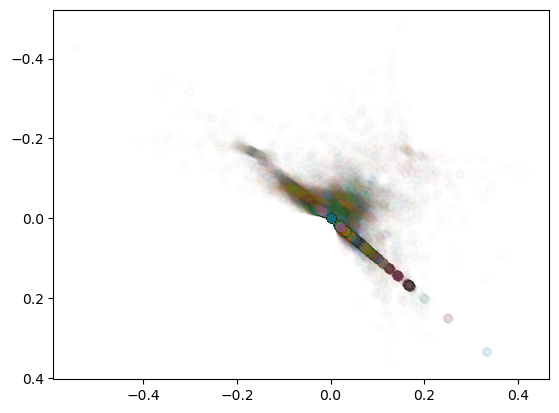

In [198]:
# L1
fig, ax = plt.subplots()
ax.invert_yaxis()

for sample in normalized_samples:
    ax.scatter(sample[:,0], sample[:,1], alpha=0.01)

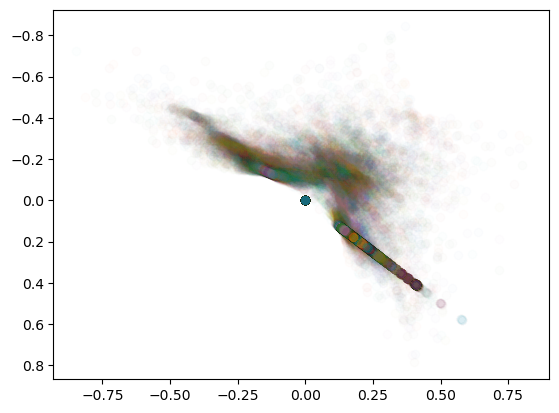

In [206]:
# L2
fig, ax = plt.subplots()
ax.invert_yaxis()

for sample in normalized_samples:
    ax.scatter(sample[:,0], sample[:,1], alpha=0.01)

In [14]:
tf.keras.backend.clear_session()

# def get_model():
#     inputs = layers.Input((32, 543, 3))
#     x = layers.ConvLSTM1D(16, 2)(inputs)
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(250, activation="softmax")(x)
    
#     return models.Model(inputs, x)


def conv1d_lstm_block(inputs, filters):
    vector = tf.keras.layers.ConvLSTM1D(filters=32, kernel_size=8)(inputs)
    for f in filters:
        vector = tf.keras.layers.Conv1D(filters=f, kernel_size=8)(vector)
        vector = tf.keras.layers.MaxPooling1D()(vector)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    return vector

def get_model():
    inputs = tf.keras.Input((NUM_FRAMES, 543, 3), dtype=tf.float32)

    # Features
    face_inputs = inputs[:, :, 0:468, :]
    left_hand_inputs = inputs[:, :, 468:489, :]
    pose_inputs = inputs[:, :, 489:522, :]
    right_hand_inputs = inputs[:, :,522:,:]

    face_vector = conv1d_lstm_block(face_inputs, [32, 64])
    left_hand_vector = conv1d_lstm_block(left_hand_inputs, [64])
    right_hand_vector = conv1d_lstm_block(right_hand_inputs, [64])
    pose_vector = conv1d_lstm_block(pose_inputs, [64])
    
    vector = tf.keras.layers.Concatenate(axis=1)([face_vector, left_hand_vector, right_hand_vector, pose_vector])
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model


model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 543, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 16, 468, 3)  0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 461, 32)      35968       ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

In [15]:
model.compile(
    "adam",
    "binary_crossentropy",
    metrics=["acc"]
)

In [16]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds
)

Epoch 1/10
585/585 [==============================] - 211s 337ms/step - loss: 0.0301 - acc: 0.0059 - val_loss: 0.0250 - val_acc: 0.0248
Epoch 2/10
585/585 [==============================] - 183s 313ms/step - loss: 0.0235 - acc: 0.0449 - val_loss: 0.0216 - val_acc: 0.0952
Epoch 3/10
585/585 [==============================] - 182s 311ms/step - loss: 0.0209 - acc: 0.1206 - val_loss: 0.0194 - val_acc: 0.1843
Epoch 4/10
585/585 [==============================] - 183s 312ms/step - loss: 0.0190 - acc: 0.1978 - val_loss: 0.0181 - val_acc: 0.2439
Epoch 5/10
585/585 [==============================] - 182s 310ms/step - loss: 0.0178 - acc: 0.2544 - val_loss: 0.0171 - val_acc: 0.2846
Epoch 6/10
585/585 [==============================] - 181s 310ms/step - loss: 0.0170 - acc: 0.2915 - val_loss: 0.0175 - val_acc: 0.2739
Epoch 7/10
585/585 [==============================] - 181s 310ms/step - loss: 0.0164 - acc: 0.3195 - val_loss: 0.0173 - val_acc: 0.2855
Epoch 8/10
585/585 [============================

In [17]:
model.evaluate(valid_ds)

154/154 [==============================] - 10s 66ms/step - loss: 0.0159 - acc: 0.3494


[0.015903348103165627, 0.3493902385234833]

In [18]:
model.save("models/baseline")

INFO:tensorflow:Assets written to: baseline/assets


INFO:tensorflow:Assets written to: baseline/assets


## Inference

In [7]:
ROWS_PER_FRAME = 543  # number of landmarks per frame
SAMPLE_FILE = "train_landmark_files/2044/635217.parquet"

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

frames = load_relevant_data_subset(SAMPLE_FILE)

In [8]:
frames.shape

(7, 543, 3)

In [29]:
class DataPreprocessing(tf.Module):
    def __init__(self, num_frames=NUM_FRAMES, name=None):
        super().__init__(name=name)
        self.num_frames = num_frames
        
    def true_fn(self, frames, n_frames):
        num_left_frames = self.num_frames - n_frames
        left_frames = tf.zeros(shape=(num_left_frames, 543, 3))
        frames = tf.concat([frames, left_frames], 0)

        return frames

    def false_fn(self, frames):
        frames = tf.slice(
            frames,
            begin=[0,0,0],
            size=[self.num_frames, 543, 3]
        )

        return frames
    
    def shape_list(self, tensor):
        """
        Deal with dynamic shape in tensorflow cleanly.
        Args:
            tensor (`tf.Tensor` or `np.ndarray`): The tensor we want the shape of.
        Returns:
            `List[int]`: The shape of the tensor as a list.
        """
        if isinstance(tensor, np.ndarray):
            return list(tensor.shape)

        dynamic = tf.shape(tensor)

        if tensor.shape == tf.TensorShape(None):
            return dynamic

        static = tensor.shape.as_list()

        return [dynamic[i] if s is None else s for i, s in enumerate(static)]

    def __call__(self, frames):
        n_frames, _, _ = self.shape_list(frames)
        
        # nan to num
        frames = tf.where(tf.math.is_nan(frames), 0.0, frames)

        # sample frames
        frames = tf.cond(
            tf.less(n_frames, NUM_FRAMES),
            true_fn = lambda: true_fn(frames, n_frames),
            false_fn = lambda: false_fn(frames),
        )

        return tf.expand_dims(frames, axis=0)

In [30]:
model = tf.keras.models.load_model("models/baseline")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 543, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 16, 468, 3)  0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 461, 32)      35968       ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

In [35]:
class TFLiteModel(tf.keras.Model):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ASL model 
    """

    def __init__(self, asl_model):
        """
        Initializes the TFLiteModel with the specified feature generation model and main model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = DataPreprocessing()
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def call(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.model(x)[0, :]

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

tflite_keras_model = TFLiteModel(model)
demo_output = tflite_keras_model(load_relevant_data_subset(SAMPLE_FILE))["outputs"]
np.argmax(demo_output.numpy(), axis=-1)

30

In [38]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
tflite_model = keras_model_converter.convert()
with open('models/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip models/model.tflite

import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("models/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(SAMPLE_FILE))
sign = np.argmax(output["outputs"])

print(sign)

INFO:tensorflow:Assets written to: /tmp/tmp0khadsct/assets


INFO:tensorflow:Assets written to: /tmp/tmp0khadsct/assets
2023-03-09 22:16:07.988475: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-09 22:16:07.988535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-09 22:16:07.989575: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0khadsct
2023-03-09 22:16:08.035732: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-09 22:16:08.035782: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0khadsct
2023-03-09 22:16:08.186827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-09 22:16:08.218611: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-09 22:16:08.457056: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

  adding: models/model.tflite (deflated 9%)
30
